## Import libs, set paths and load params

In [4]:
import os
import numpy as np
import pandas as pd
import sys
import csv
sys.path.insert(0, "../src")
ART_NET_PATH = "../networks"

import auxilary_functions as f
from generation_algorithm import *
from copy import deepcopy
import networkx as nx
from time import sleep
import statistics
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Yeast Tnet and select the FFL-based component

In [5]:
interaction_matrix = f.get_interaction_matrix(cfg)

%time
motifs, counter = f.motif_search(cfg, interaction_matrix, batch_size=10000)
motifs_orig = motifs["030T"]
counter

ffl_nodes = list(set(sum([list(map(int, x.split("_"))) for x in motifs_orig], [])))
interaction_matrix_ffl = np.zeros((len(ffl_nodes), len(ffl_nodes)))
for motif in motifs_orig:
    motif = f.split_motif(motif)
    motif_new = list(ffl_nodes.index(x) for x in motif)
    interaction_matrix_ffl[np.ix_(motif_new, motif_new)] = \
    interaction_matrix[np.ix_(motif, motif)]
interaction_matrix_ffl.shape, interaction_matrix_ffl.sum()

# Vertex-based motif network on FFL
motifs_network = f.build_vmn(motifs_orig, verbose=True)
V = nx.Graph(motifs_network)
nx.is_connected(V)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


100%|██████████| 5676765/5676765 [00:15<00:00, 377717.60it/s]


True

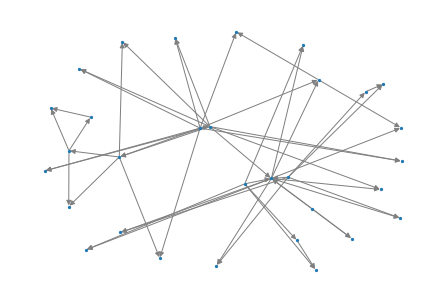

In [6]:
substrate_matrix = get_network_nucleus(
        interaction_matrix, motifs=motifs_orig, motifs_network=motifs_network, min_size=30
    )

substrate_matrix_t = substrate_matrix.transpose()
substrate_matrix_graph = nx.DiGraph(substrate_matrix_t)
nx.draw(substrate_matrix_graph, node_size = 5, edge_color = 'gray')

In [7]:
substrate_matrix_graph.out_degree()

OutDegreeView({0: 2, 1: 0, 2: 9, 3: 9, 4: 0, 5: 0, 6: 5, 7: 6, 8: 0, 9: 0, 10: 4, 11: 0, 12: 3, 13: 8, 14: 0, 15: 0, 16: 0, 17: 1, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 2, 27: 0, 28: 0, 29: 1, 30: 0})

In [8]:
substrate_matrix_graph.in_degree()

InDegreeView({0: 2, 1: 2, 2: 4, 3: 0, 4: 2, 5: 2, 6: 0, 7: 0, 8: 2, 9: 2, 10: 2, 11: 2, 12: 1, 13: 1, 14: 2, 15: 2, 16: 2, 17: 1, 18: 2, 19: 2, 20: 1, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 0, 27: 2, 28: 2, 29: 1, 30: 2})

## Topology stats

In [9]:
def collect_topology_stats(growth_pace_vec, matrix_size_vec, initial_size_vec, barabasi_num_vec):
    network_topology_stats = {}
    #import resource
    
    for growth_pace_num in growth_pace_vec:
        for final_size in matrix_size_vec:
            for initial_size in initial_size_vec:
                for barabasi_num in barabasi_num_vec:
                
                    #generate network
                    artificial_matrix_ffl = generate_artificial_network(
                        interaction_matrix, motifs=motifs_orig, motifs_network=motifs_network,
                        nucleus_size=initial_size, network_size=final_size, growth_pace=growth_pace_num,
                        reference_matrix=interaction_matrix_ffl, growth_barabasi = barabasi_num, sparsity=3)
                    
                    ffl_perc = artificial_matrix_ffl[3]
                    sparsity = artificial_matrix_ffl[2]
                    time_spent = artificial_matrix_ffl[1]
                    artificial_matrix_ffl = artificial_matrix_ffl[0]

                    #GS-to-Networkx format conversion
                    art_matrix = artificial_matrix_ffl.transpose()

                    if not os.path.exists(ART_NET_PATH):
                            os.mkdir(ART_NET_PATH)
                    joblib.dump(
                            art_matrix, os.path.join(ART_NET_PATH,'_'+f"test{art_matrix.shape[0]}.gz")

                    )

                    #create edgelist
                    D1 = nx.DiGraph(art_matrix)
                    nx.write_edgelist(D1, os.path.join(ART_NET_PATH, "test.tsv"), data=False)

                    #analyze network
                    network_test = f.read_df_as_network(os.path.join(ART_NET_PATH, "test.tsv"))
                    diameter = nx.diameter(network_test)
                    shortest_path = nx.average_shortest_path_length(network_test)

                    #collect stats
                    key_to_dic = '_'.join(str(x) for x in [final_size,initial_size,growth_pace_num,barabasi_num])
                    list_with_stats = [final_size, initial_size, sparsity,
                                       np.round(shortest_path, 4), diameter, growth_pace_num, barabasi_num, ffl_perc, time_spent]
                    network_topology_stats[key_to_dic] = list_with_stats

    return network_topology_stats

In [13]:
dict_with_stats = collect_topology_stats([0.4],[150,200,250],[30],[0.2])

Nucleus matrix shape: (31, 31)



1.94
Network has been successfully generated!
Total time spent: 0:00:11.819594
links_per_node: 3.0


AttributeError: '_io.TextIOWrapper' object has no attribute 'read_df_as_network'

In [11]:
list_with_stats = list(dict_with_stats.values())
csv_columns = ['size','nucleus_size', 'sparsity', 'shortest_path', 'diameter', 'growth_pace', 'barabasi', 'ffl_perc', 'time_spent']
list_with_stats.insert(0,csv_columns)

with open("../networks/topology_stats.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(list_with_stats)

In [12]:
topology_data = pd.read_csv("../networks/topology_stats.csv",header=0, delimiter=",")
topology_data

,size,nucleus_size,sparsity,shortest_path,diameter,growth_pace,barabasi,ffl_perc,time_spent
0,150,30,3.0,2.6787,4,0.4,0.3,0.333333,0:00:09.912201
1,200,30,3.0,2.7521,5,0.4,0.3,0.288557,0:00:10.944655
2,250,30,3.0,2.8338,5,0.4,0.3,0.254980,0:00:13.050742


In [7]:
topology_data = pd.read_csv("../networks/topology_stats.csv",header=0, delimiter=",")
topology_data

,size,nucleus_size,sparsity,shortest_path,diameter,growth_pace,barabasi,time_spent
0,150,30,7.644860,2.3812,4,0.1,0.01,0:09:30.777412
1,150,30,5.300000,2.8230,5,0.1,0.10,0:00:26.876021
2,150,30,3.878049,2.8983,5,0.1,0.20,0:00:10.374069
3,150,30,3.522727,3.0113,6,0.1,0.30,0:00:10.125607
4,150,30,2.916667,3.1590,6,0.1,0.40,0:00:08.715911
5,150,30,2.542857,3.1715,7,0.1,0.50,0:00:09.252426
6,150,30,2.193548,3.3288,7,0.1,0.60,0:00:08.894882
7,150,30,2.161290,3.3879,7,0.1,0.70,0:00:08.283033
8,150,30,1.900000,3.4859,8,0.1,0.80,0:00:08.030689
9,150,30,1.870968,3.7312,7,0.1,0.90,0:00:07.511712


<AxesSubplot:>

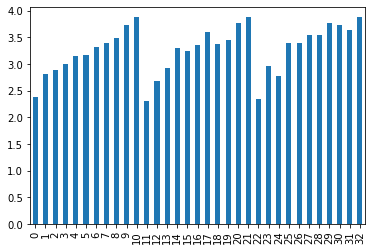

In [8]:
topology_data['shortest_path'].plot(kind='bar')

## Visualize network

In [1]:
def read_df_as_network(filename):
    with open(filename, 'rt') as f:
        network_df = pd.read_csv(f, sep=' ', header = None)
        network = nx.from_pandas_edgelist(network_df, create_using=nx.DiGraph(), source = 0, target = 1)
        return network
    
network_test = read_df_as_network(os.path.join(ART_NET_PATH, "test.tsv"))

NameError: name 'os' is not defined

In [10]:
print(len(network_test.nodes))

300


### Network

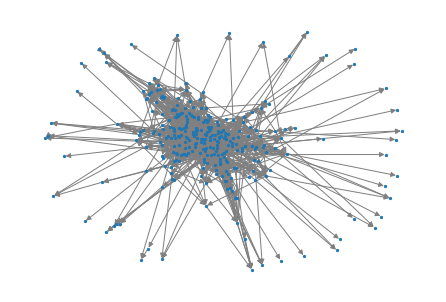

In [11]:
nx.draw(network_test, node_size = 5, edge_color = 'gray')

In [55]:
# def list_to_dictionary(your_list):
    
#     from collections import defaultdict
    
#     d = defaultdict(list)

#     for key, value in your_list:
#         d[key].append(value)
        
#     return d

# def get_degree_values(network):
    
#     in_degree_list = list_to_dictionary(list(network_test.in_degree()))
#     out_degree_list = list_to_dictionary(list(network_test.out_degree()))

#     return in_degree_list.keys(), np.concatenate(list(in_degree_list.values())),\
#     np.concatenate(list(out_degree_list.values()))

# nodes, in_degree, out_degree = get_degree_values(network_test)
# print(list(nodes))
# print(in_degree/sum(in_degree))
# print(out_degree/sum(out_degree))

# in_probs = pd.Series(nodes, in_degree/sum(in_degree))
# out_probs = pd.Series(nodes, out_degree/sum(out_degree))

### Minimum spanning tree

In [13]:
tree = nx.minimum_spanning_tree(network_test)
nx.draw(tree, node_size = 5, edge_color = 'gray')

NetworkXNotImplemented: not implemented for directed type

In [14]:
nx.diameter(network_test)

NetworkXError: Found infinite path length because the digraph is not strongly connected

In [65]:
nx.average_shortest_path_length(network_test)

AttributeError: 'list' object has no attribute 'is_directed'

In [63]:
degrees = [network_test.degree(n) for n in network_test.nodes()]
print(statistics.mean(degrees))

AttributeError: 'list' object has no attribute 'nodes'

In [64]:
plt.figure(figsize=(15, 10), dpi=80)
network_test = [d for n, d in network_test.degree]
plt.hist(network_test, bins=100, alpha=0.75)

AttributeError: 'list' object has no attribute 'degree'

<Figure size 1200x800 with 0 Axes>